In [5]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [6]:
from gif_reading import *
from gif_utils import *

In [7]:
gif_folder = r"C:/Users/shashg/Documents/gifs"
gif_file = r"C:/Users/shashg/Documents/gifs/24 deg FG 10mg_ml b.gif"

In [50]:
def calcGIF(gif):
    frame = gif if type(gif) is np.ndarray else getMaxFrame(gif) 
    regions = getRegionsOfInterest(frame)
    return (regions, frame)

def getRegionsOfInterest(frame):
    regions = {}
    break_loop = False
    hsv_img = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    for hue in range(90, 131, 3):
        for saturation in range(20, 255, 5):
            ranges =  [np.array([0,0,0]) ,np.array([hue, saturation, 255])]
            mask = cv2.inRange(hsv_img, ranges[0], ranges[1])
            contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            #print(f"Hue: {hue} Saturation:{saturation}")
            if contours:
                #print('\t Contours Found')
                i = frame.copy()
                for contour in contours:
                    x,y,w,h = cv2.boundingRect(contour)
                    if h >=10 and w >=10:
                        #print(f"\t \t Suitable Contour Found at {x,y,w,h}")
                        cropped = frame[y:y+h, x:x+w]
                        regions[np.mean(cropped)] = {'x':[x, x+w], 'y':[y,y+h], 'hue':hue, 'saturation':saturation, 'region':cropped}
                        #print(f"\t \t \t Added contour to regions Mean = {np.mean(cropped)}")
    return regions

In [51]:
def getMaxMean(roi_mean, roi, frame):
    x1, x2 = roi['x']
    y1,y2 = roi['y']
    roi_height  = y2-y1
    roi_width = x2-x1
    gmax_height = roi_height // 2
    gmax_width = roi_width // 2
    gmax = grayMaxIntensity(frame, (gmax_width,gmax_width, gmax_height,gmax_height))
    max_gmax = grayMaxIntensity(frame, (5,5,5,5))
    while gmax_height > 5 or gmax_width > 5:
        gmax_height -= 1 if gmax_height > 5 else 0 
        gmax_width -= 1 if gmax_width > 5 else 0
        gmax = grayMaxIntensity(frame, (gmax_width,gmax_width, gmax_height,gmax_height))
        if gmax['mean'] > roi_mean and gmax['mean'] > max_gmax['mean']:
            break
    return gmax

In [77]:
gif_means = {}
for gif in os.listdir(gif_folder):
    gif_path = os.path.join(gif_folder, gif)
    regionsOfInterest, frame = calcGIF(gif_path)
    roi_mean = max(regionsOfInterest.keys())
    x1, x2 = regionsOfInterest[roi_mean]['x']
    y1,y2 = regionsOfInterest[roi_mean]['y']
    roi_height  = y2-y1
    roi_width = x2-x1
    gmax = getMaxMean(roi_mean,regionsOfInterest[roi_mean],frame)
    gmax_height = gmax['y'][0] - gmax['y'][1]
    gmax_width = gmax['x'][0] - gmax['x'][1]
    gif_means[gif] = {'ROI': [roi_mean, regionsOfInterest[roi_mean],roi_height, roi_width], 'Gray Max': [gmax['mean'], gmax, gmax_height, gmax_width], 'frame':frame}
for gif, methods in gif_means.items():
    print(f"{gif}:")
    for method, stuff in methods.items():
        if type(stuff) == list:
            [mean, props, h,w] = stuff
            print(f"\t {method.lower().capitalize()} method:")
            print(f"\t \t Mean: {mean}, X: {props['x']} Y: {props['y']} h: {h} w: {w} max:{np.max(cv2.cvtColor(props['region'], 6))} {'' if 'hue' not in props else props['hue']} {'' if 'saturation' not in props else props['saturation']}")
    print(f"\t Max : {np.max(cv2.cvtColor(gif_means[gif]['frame'], 6))}")
    

24 deg FG 10mg_ml a.gif:
	 Roi method:
	 	 Mean: 15.983644665836447, X: [377, 450] Y: [405, 460] h: 55 w: 73 max:16 129 220
	 Gray max method:
	 	 Mean: 16.881666666666668, X: [475, 455] Y: [427, 417] h: 10 w: 20 max:16  
	 Max : 17
24 deg FG 10mg_ml b.gif:
	 Roi method:
	 	 Mean: 9.18452380952381, X: [70, 86] Y: [437, 451] h: 14 w: 16 max:10 129 250
	 Gray max method:
	 	 Mean: 6.2555555555555555, X: [103, 93] Y: [644, 634] h: 10 w: 10 max:13  
	 Max : 13
24 deg FG 10mg_ml c.gif:
	 Roi method:
	 	 Mean: 8.32695374800638, X: [311, 330] Y: [261, 272] h: 11 w: 19 max:7 129 250
	 Gray max method:
	 	 Mean: 10.74, X: [46, 36] Y: [33, 23] h: 10 w: 10 max:15  
	 Max : 15
24 deg FG 10mg_ml d.gif:
	 Roi method:
	 	 Mean: 14.778554778554778, X: [115, 128] Y: [311, 333] h: 22 w: 13 max:13 123 250
	 Gray max method:
	 	 Mean: 9.805555555555555, X: [418, 408] Y: [644, 634] h: 10 w: 10 max:18  
	 Max : 18
24 deg FG 10mg_ml e.gif:
	 Roi method:
	 	 Mean: 14.77878787878788, X: [110, 121] Y: [431, 441

In [71]:
def checkLogic(row, col,xp,xd,yp,yd):
    frame_height, frame_width = 640,480
    if row + yp > frame_height:
        print(f"row2 ({row+yp}) bigger than frame height ({frame_height}) by {row+yp-frame_height}")
        yd += yp - (frame_height-row)
        print(f"\t yd is equal to {yd}")
        yp = frame_height-row
        print(f"\t yp is equal to {yp}")
    elif row-yd < 0:
        print(f"Row 1 {row-yd} is less than 0")
        yp += abs(row-yd)
        print(f"YP = {yp}")
        yd = row
        print(f"YD = {yd}")
    if col+xp > frame_width:
        print(f"Col2 ({col+xp}) > frame width {frame_width}")
        print(f"xd -> xd({xd}) + xp ({xp}) - (frame_width({frame_width}) - col {col}) -> {xd+(xp - (frame_width-col))}")
        xd += xp - (frame_width-col)
        print(f"xp -> frame_width {frame_width} - col ({col}) -> {frame_width-col}")
        xp = frame_width-col
        print(f"xp -> {xp}")
    elif col-xd < 0:
        print(f"col 1 {col-xd} is less than 0")
        xp += abs(col-xd)
        print(f"XP -> {xp}")
        xd = col

    print(f"Y2 = {row+yp}, Y1 = {row-yd}, X2 = {col+xp}, X1 = {col-xd}")

In [73]:
checkLogic(390,479, 5,5,5,5)

Col2 (484) > frame width 480
xd -> xd(5) + xp (5) - (frame_width(480) - col 479) -> 9
xp -> frame_width 480 - col (479) -> 1
xp -> 1
Y2 = 395, Y1 = 385, X2 = 480, X1 = 470


In [3]:
import imageio

In [8]:
gif = imageio.mimread(gif_file)
grayscale_frames = [np.asarray(imageio.imutils.imresize(frame, interp='nearest', size=(height, width, 3)), dtype=np.uint8) for frame in gif]
grayscale_frames = [np.mean(frame, axis=2, dtype=np.uint8) for frame in grayscale_frames]


AttributeError: module 'imageio' has no attribute 'imutils'

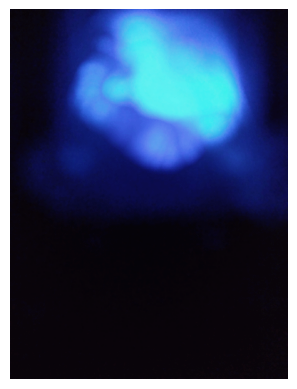

In [45]:
import imageio
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Read the GIF file
gif_path = 'C:/Users/shashg/Documents/gifs/3mM L+C 7mM H2o2 b.gif'
frames = getFrames(gif_path)

max_intensity_projection = np.max(frames, axis=0)

# Display the maximum intensity projection
plt.imshow(cv2.cvtColor(max_intensity_projection,4))
plt.axis('off')
plt.show()
